# Spain Grid — Illustrative Example

This notebook produces illustrative figures for the Spanish grid,
including:

1. A full-network map with temperature overlay
2. Conductor-level thermal analysis along a specific transmission line
3. Standalone colourbar figures

The example uses a single heatwave scenario (July 2026, based on the
2022 historical event) to show how spatially varying weather conditions
affect line capacity along segmented conductors.

## 1. Imports

In [1]:
import os
import sys
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cur_dir = os.path.dirname(os.path.abspath(os.getcwd()))
par_dir = os.path.dirname(cur_dir)
sys.path.append(os.path.join(os.getcwd(), ".."))

from TDOPF_eur import *
from data_config import *
from utils.plot_utils import *
from utils.network_process_utils import *

## 2. Configuration

OPF parameters, conductor specification (Al/St 240/40, 4-bundle,
380 kV), and weather template following IEEE Std 738.

In [2]:
# --- OPF parameters -------------------------------------------------------
args = {
    'date': None,
    'BaseMVA': 100.0,
    'phase_factor': 3.0,               # balanced 3-phase ACOPF
    'renewable_mode': True,
    'heatwave_mode': True,
    'storage_mode': True,
    'load_growth': True,               # 1.1 % base load growth 2020–2050
    'reactive_demand_ratio': 0.15,
    'reactive_gen_upper': 0.8,
    'reactive_gen_lower': -0.8,
    'voltage_upper': 1.05,
    'voltage_lower': 0.95,
    'phase_angle_upper': 30,
    'phase_angle_lower': -30,
}

# --- Conductor: Al/St 240/40, 4-bundle, 380 kV --------------------------
conductor = {
    'diameter': 18.881e-3,              # m  (√((240+40)/π) × 2 per sub-conductor)
    'num_bundle': 4,
    'ref_temperature': 20.0,            # °C
    'max_temperature': 90.0,            # °C
    'resistance_ratio': 0.00429,        # Ω/°C
    'unit_resistance': 0.03e-3 * 4,     # Ω/m (4-bundle)
    'conductor_angle': 0.0,
    'elevation': None,
    'convective_correction': 0.8,
    'radiactive_correction': 0.8,
}
args['max_temperature'] = conductor['max_temperature']

# --- Weather template (IEEE Std 738) — spatial fields filled later -------
weather = {
    'wind_speed': None,                 # m/s
    'wind_height': 10,
    'wind_angle': 90.0,                 # degree
    'air_density': 1.029,               # kg/m³
    'air_viscosity': 2.043e-5,          # kg/(m·s)
    'air_conductivity': 0.02945,        # W/(m·°C)
    'air_temperature': None,            # °C
    'radiation_emissivity': 0.8,
    'solar_absorptivity': 0.8,
    'solar_heat_intensity': None,       # W/m²
}

## 3. Load Network & Select Scenario

Load the Spanish network, read the experiment CSV, and select one
representative heatwave scenario for illustration.

In [ ]:
country_code = 'ES'
network, regions = load_network_EU([country_code], RATIO)
n_bus = network.buses.shape[0]

load_rate = 1.01
storage_state = 0.8
csv_path = (
    cur_dir
    + f'/models/{country_code}/{country_code}_{n_bus}_bus'
    + f'_renewable_True_heatwave_True_storage_True_{storage_state}'
    + f'_load_growth_True_{load_rate}_max_temp_90'
    + f'_model_analysis.csv'
)
df = pd.read_csv(csv_path)

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/vis/../data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [7]:
# --- Select one scenario: July 2026, 14:00, historical base year 2022 ----
fut_year = 2026
heatwave_year = 2022
heatwave_index = 1
TDPF_solver = 'td_seg_derate_iter_2'

sub_df = df[
    (df['TDPF_solver'] == TDPF_solver)
    & (df['fut_heatwave_year'] == fut_year)
]
valid = (
    (sub_df['fut_heatwave_month'] == 7)
    & (sub_df['fut_heatwave_hour'] == 14)
)
fut_heatwave_date = sub_df.loc[valid, 'fut_heatwave_date'].unique()[0]

sub2 = sub_df[sub_df['fut_heatwave_date'] == fut_heatwave_date]
fut_fmt = datetime.strptime(
    fut_heatwave_date, '%Y-%m-%d %H:%M:%S'
).strftime('%Y-%m-%d %H:%M:%S')

his_valid = sub2['his_heatwave_year'] == heatwave_year
his_heatwave_date = sub2.loc[his_valid, 'his_heatwave_date'].unique()[0]
his_fmt = datetime.strptime(
    his_heatwave_date, '%Y-%m-%d'
).strftime('%Y-%m-%d %H:%M:%S')

# Load weather cutout
weather_path = (
    cur_dir
    + f'/models/{country_code}/simu_data'
    + f'/future_weather_data_based_on_historical'
    + f'_hot_event_{heatwave_year}_{heatwave_index}.nc'
)
weather_cutout = xr.open_dataset(weather_path)
weather_cutout = weather_cutout.sel(time=fut_fmt)
temperature = weather_cutout['temperature'].data - TK

# Load OPF result
expr_id = (
    f'{country_code}_{n_bus}_{TDPF_solver}_{fut_fmt}_{his_fmt}'
    f'_storage_{storage_state}_load_growth_{load_rate}_thermal_90_results.npy'
)
result = np.load(
    cur_dir + f'/models/{country_code}/ppc/{fut_fmt}/{expr_id}',
    allow_pickle=True,
).item()

## 4. Network Overview Map

Full Spanish grid overlaid on the air-temperature pcolormesh.

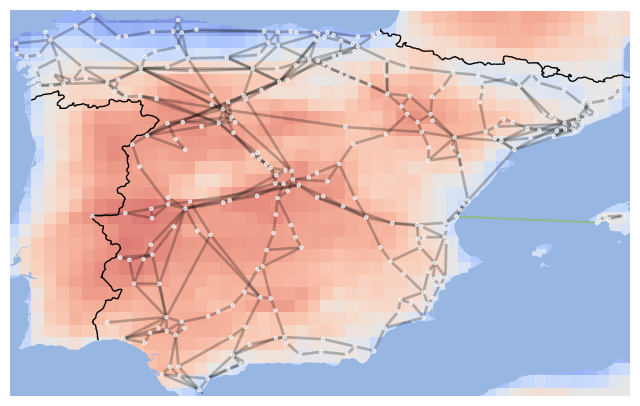

In [ ]:
lon_grid = weather_cutout['x'].data - 0.125
lat_grid = weather_cutout['y'].data - 0.125
boundaries = [
    network.buses.x.min() - 0.125, network.buses.x.max() + 0.125,
    network.buses.y.min() - 0.125, network.buses.y.max() + 0.125,
]

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.pcolormesh(
    lon_grid, lat_grid, temperature, shading='auto',
    cmap='coolwarm', norm=plt.Normalize(vmin=20, vmax=50),
    alpha=0.7, zorder=0,
)
ax.add_feature(cfeature.OCEAN, zorder=1)
ax.add_feature(cfeature.BORDERS, zorder=1)

network.plot(
    bus_sizes=0.001,
    bus_colors='lightgray',
    bus_alpha=0.75,
    line_widths=2,
    line_colors='black',
    line_alpha=0.25,
    geomap=False,
    boundaries=boundaries,
)
plt.savefig(
    MODELS + f'/Intro/{country_code}_network_flow_distribution.pdf',
    dpi=500, bbox_inches='tight',
)

## 5. Conductor-Level Thermal Analysis

Compute the maximum allowable current along each line segment, then
zoom in on the most thermally stressed line to visualise how capacity
varies spatially along the conductor.

In [9]:
# --- Populate weather fields from the cutout ------------------------------
network_load_weather(network, regions, weather_cutout)
segment_wea = copy.deepcopy(network.segment_weather)
bus_wea = copy.deepcopy(
    network.buses[['temperature', 'wnd10m', 'influx',
                    'wnd_azimuth', 'height']].values
)

seg_prop = network.segments[:, :, 2]
weather['air_temperature'] = segment_wea[:, :, 0]
weather['wind_speed'] = segment_wea[:, :, 1]
weather['solar_heat_intensity'] = segment_wea[:, :, 2]
weather['wind_angle'] = segment_wea[:, :, 3]
conductor['elevation'] = segment_wea[:, :, 4]
network.num_bundle = conductor['num_bundle']

# Conductor bearing angle
xe = (network.buses.loc[network.lines['bus1'], ['x', 'y']].values
      - network.buses.loc[network.lines['bus0'], ['x', 'y']].values)
conductor['conductor_angle'] = np.reshape(
    (90 - np.rad2deg(np.arctan2(xe[:, 1], xe[:, 0]))) % 360, (-1, 1)
)
conductor['num_parallel'] = network.lines['num_parallel'].values

# Maximum allowable current per segment
Imax = maximum_allowable_current(conductor, weather)
Imax = Imax * conductor['num_bundle']
i_nom = network.lines.i_nom.values * 1000

# Estimated capacity drop per segment and per line
est_capacity_drop = np.clip(Imax / i_nom[:, None], 0, 1)
seg_capacity_drop = est_capacity_drop.min(axis=1)

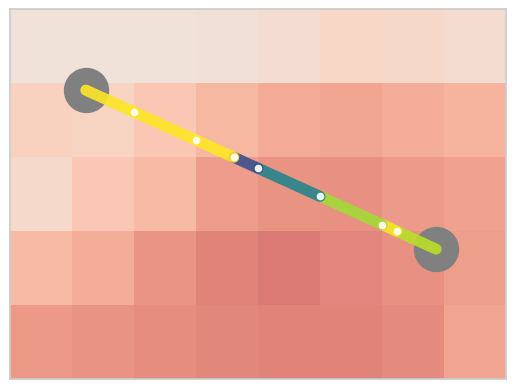

In [ ]:
# --- Zoom into the most thermally stressed line --------------------------
index = seg_capacity_drop.argmin()
Ilim = est_capacity_drop[index, seg_prop[index] > 0] * 100

line = network.lines.iloc[index]
bus_0 = network.buses.loc[line.bus0]
bus_1 = network.buses.loc[line.bus1]
x0, y0 = bus_0.x, bus_0.y
x1, y1 = bus_1.x, bus_1.y

# Grid-cell intersection points along the line
intersections = np.array(
    calculate_intersections(x0, y0, x1, y1, resolution=0.25)
)

# Crop the temperature grid to the line's bounding box
lon_grid = weather_cutout['x'].data
lat_grid = weather_cutout['y'].data
ix0 = min(np.argmin(abs(lon_grid - x0)), np.argmin(abs(lon_grid - x1)))
ix1 = max(np.argmin(abs(lon_grid - x0)), np.argmin(abs(lon_grid - x1)))
iy0 = min(np.argmin(abs(lat_grid - y0)), np.argmin(abs(lat_grid - y1)))
iy1 = max(np.argmin(abs(lat_grid - y0)), np.argmin(abs(lat_grid - y1)))

# Plot
plt.pcolormesh(
    lon_grid[ix0 - 1:ix1 + 2],
    lat_grid[iy0 - 1:iy1 + 2],
    temperature[iy0 - 1:iy1 + 2, ix0 - 1:ix1 + 2],
    vmin=temperature.min() + 5, vmax=temperature.max(),
    shading='nearest', cmap='coolwarm', alpha=0.7,
)
plt.grid(True, color='black', linestyle='--', linewidth=10)
plt.scatter([x0, x1], [y0, y1], s=1000, c='gray', alpha=1)

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=50, vmax=100)
for i, (start, stop) in enumerate(zip(intersections[:-1], intersections[1:])):
    xs, ys = zip(start, stop)
    plt.plot(xs, ys, color=cmap(norm(Ilim[i])), linewidth=8, alpha=0.9)
    if i > 0:
        plt.scatter(
            start[0], start[1], color='white', marker='o',
            s=20, alpha=0.9, zorder=10,
        )

plt.xticks([])
plt.yticks([])
plt.savefig(
    MODELS + f'Intro/{country_code}_line_flow_distribution.pdf',
    dpi=500, bbox_inches='tight',
)

## 6. Standalone Colourbars

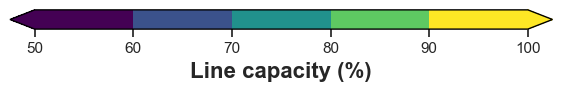

In [ ]:
# Line capacity colourbar
create_discrete_temperature_colorbar(
    cmap, num_levels=5, vmin=50, vmax=100, alpha=1,
    label='Line capacity (%)', orientation='horizontal',
    figsize=(7, 0.25), extend='both',
)
plt.tight_layout()
plt.savefig(
    MODELS + 'Intro/line_flow_colorbar.pdf', dpi=500, bbox_inches='tight',
)

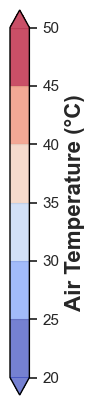

In [ ]:
# Air temperature colourbar (vertical)
create_discrete_temperature_colorbar(
    plt.cm.coolwarm, num_levels=6, vmin=20, vmax=50, alpha=0.7,
    label='Air Temperature (°C)', orientation='vertical',
    figsize=(0.25, 5), extend='both',
)
plt.tight_layout()
plt.savefig(
    MODELS + 'Intro/temperature_colorbar.pdf', dpi=500, bbox_inches='tight',
)